# Supervised Classification: Lithology Classification with Well Logs

Well log interpretation is a critical yet time-intensive task in subsurface exploration, requiring geoscientists to analyze complex datasets to infer lithology accurately. Developing an automated solution that can instantly and accurately classify lithology has significant implications for the efficiency and effectiveness of geological workflows. This project aims to address this challenge by leveraging machine learning to interpret lithology from various well logs. By utilizing logs with pre-labeled lithology data, the goal is to examine whether a robust and effective machine learning model can be developed to classify lithology reliably, streamlining interpretation and supporting more informed decision-making in geoscience applications.

## Project Setup

### Import Libraries

In [21]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
!pip install lasio
import lasio

### Import and Clean Data

In [22]:
# List of LAS file URLs (update with the actual repository's raw file URLs)
las_files = [
    "https://raw.githubusercontent.com/ed3894/GEOL-558A/main/Supervised%20Classification/Well%20Logs/15_9-14.las",
    "https://raw.githubusercontent.com/ed3894/GEOL-558A/main/Supervised%20Classification/Well%20Logs/15_9-15.las",
    "https://raw.githubusercontent.com/ed3894/GEOL-558A/main/Supervised%20Classification/Well%20Logs/15_9-17.las",
    "https://raw.githubusercontent.com/ed3894/GEOL-558A/main/Supervised%20Classification/Well%20Logs/15_9-23.las",
    "https://raw.githubusercontent.com/ed3894/GEOL-558A/main/Supervised%20Classification/Well%20Logs/16_1-2.las",
    "https://raw.githubusercontent.com/ed3894/GEOL-558A/main/Supervised%20Classification/Well%20Logs/16_1-6%20A.las"
]

# Columns to remove
columns_to_remove = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'CALI', 'MUDWEIGHT', 'ROP', 'RDEP', 'RSHA', 'RMED', 'RXO', 'X_LOC', 'Y_LOC', 'Z_LOC', 'Source', 'BS', 'DCAL', 'DCAL', 'SGR', 'ROPA', 'DTS', 'DRHO']

# Initialize an empty list to store DataFrames
dataframes = []

# Read LAS files
for i, las_url in enumerate(las_files):
    try:
        las = lasio.read(las_url)
        df = las.df()
        if not df.empty:
            df['Source'] = os.path.basename(las_url)  # Track file origin
            df['Well_ID'] = i  # Add a Well ID
            dataframes.append(df)
        else:
            print(f"No data found in file: {las_url}")
    except Exception as e:
        print(f"Error reading file {las_url}: {e}")

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Drop the specified columns first
combined_df = combined_df.drop(columns=[col for col in columns_to_remove if col in combined_df.columns], errors='ignore')

# Drop rows where Nan values are present
cleaned_df = combined_df.dropna()

# Remove rows where any of the specified columns have negative values
columns_to_check = ['PEF', 'GR', 'RHOB', 'DTC', 'NPHI']
cleaned_df = cleaned_df[(cleaned_df[columns_to_check] >= 0).all(axis=1)]


### Fix Lithology labels

In [23]:
# Define the lithology keys
lithology_keys = {
    30000: 'Sandstone',
    65030: 'Sandstone/Shale',
    65000: 'Shale',
    80000: 'Marl',
    74000: 'Dolomite',
    70000: 'Limestone',
    70032: 'Chalk',
    88000: 'Halite',
    86000: 'Anhydrite',
    99000: 'Tuff',
    90000: 'Coal',
    93000: 'Basement'
}

# Ensure the DataFrame is a copy to avoid SettingWithCopyWarning
cleaned_df = cleaned_df.copy()

# Create a new column 'Lithology' by mapping the lithology codes to descriptions
cleaned_df.loc[:, 'Lithology'] = cleaned_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys).astype(str)

# Reset the index of the DataFrame, starting from 0
cleaned_df = cleaned_df.reset_index(drop=True)

# Print the final cleaned DataFrame
print("Final DataFrame shape:", cleaned_df.shape)

# Print the first few rows to confirm
print("----------------------------------------------")
print('First Few Rows:')
print(cleaned_df.head())

Final DataFrame shape: (43042, 10)
----------------------------------------------
First Few Rows:
   FORCE_2020_LITHOFACIES_LITHOLOGY         SP         DTC      NPHI  \
0                           65000.0  35.525719  174.347092  0.551575   
1                           65000.0  36.158520  176.112915  0.547566   
2                           65000.0  36.873703  177.662476  0.551840   
3                           65000.0  37.304054  177.437714  0.552511   
4                           65000.0  37.864922  176.797653  0.566789   

         PEF         GR      RHOB    DEPTH_MD  Well_ID Lithology  
0  55.815659  72.078377  2.171173  480.627991        0     Shale  
1  41.862537  72.147697  2.171840  480.779999        0     Shale  
2  38.587872  75.074219  2.161303  480.932007        0     Shale  
3  41.417999  80.735229  2.151947  481.084015        0     Shale  
4  49.471237  81.665024  2.143010  481.235992        0     Shale  


**My data importation is relatively straight forward. For each well, I am assigning a number to reference back to the well. As I import each .las file, I remove any columns I don't want to analyze, then append all of those values to one large dataframe. Once that dataframe containing all of the well data is created, I remove rows with Nan values. This ensures I can analyze all of the pertinent wells at any given row. I also remove rows where there is an unrealistic value, such as negative density values. The lithology labels are numbers, but I want the labels to be more intuitive, so I am implementing a dictionary to convert those to text. This will make interpretations much easier later on. This data cleaning process has left me with 43,042 rows and 10 columns, which should be more than enough for data analysis.**

## EDA

### Data Statistics

In [24]:
# Calculate pertinent stats of cleaned data
cleaned_df.describe()

,FORCE_2020_LITHOFACIES_LITHOLOGY,SP,DTC,NPHI,PEF,GR,RHOB,DEPTH_MD,Well_ID
count,43042.000000,43042.000000,43042.000000,43042.000000,43042.000000,43042.000000,43042.000000,43042.000000,43042.000000
mean,61824.529483,52.129988,122.962045,0.397358,3.751938,55.768951,2.141626,1987.625995,0.915524
std,13320.863484,25.966610,31.810022,0.135041,4.764189,26.250994,0.221359,673.962694,0.827110
min,30000.000000,7.232959,7.415132,0.018600,1.202017,5.951932,1.396819,480.627991,0.000000
25%,65000.000000,34.291347,91.816708,0.282254,2.307621,39.211577,1.991043,1459.836517,0.000000
50%,65000.000000,39.945309,135.773865,0.452325,3.029076,58.265293,2.070847,2005.041016,1.000000
75%,65030.000000,67.632652,147.492432,0.499138,4.309851,71.978130,2.300703,2555.587585,2.000000
max,99000.000000,137.085587,205.208664,0.733152,288.103638,804.298950,2.906611,3198.760010,2.000000


### Seaborn Pair Plot

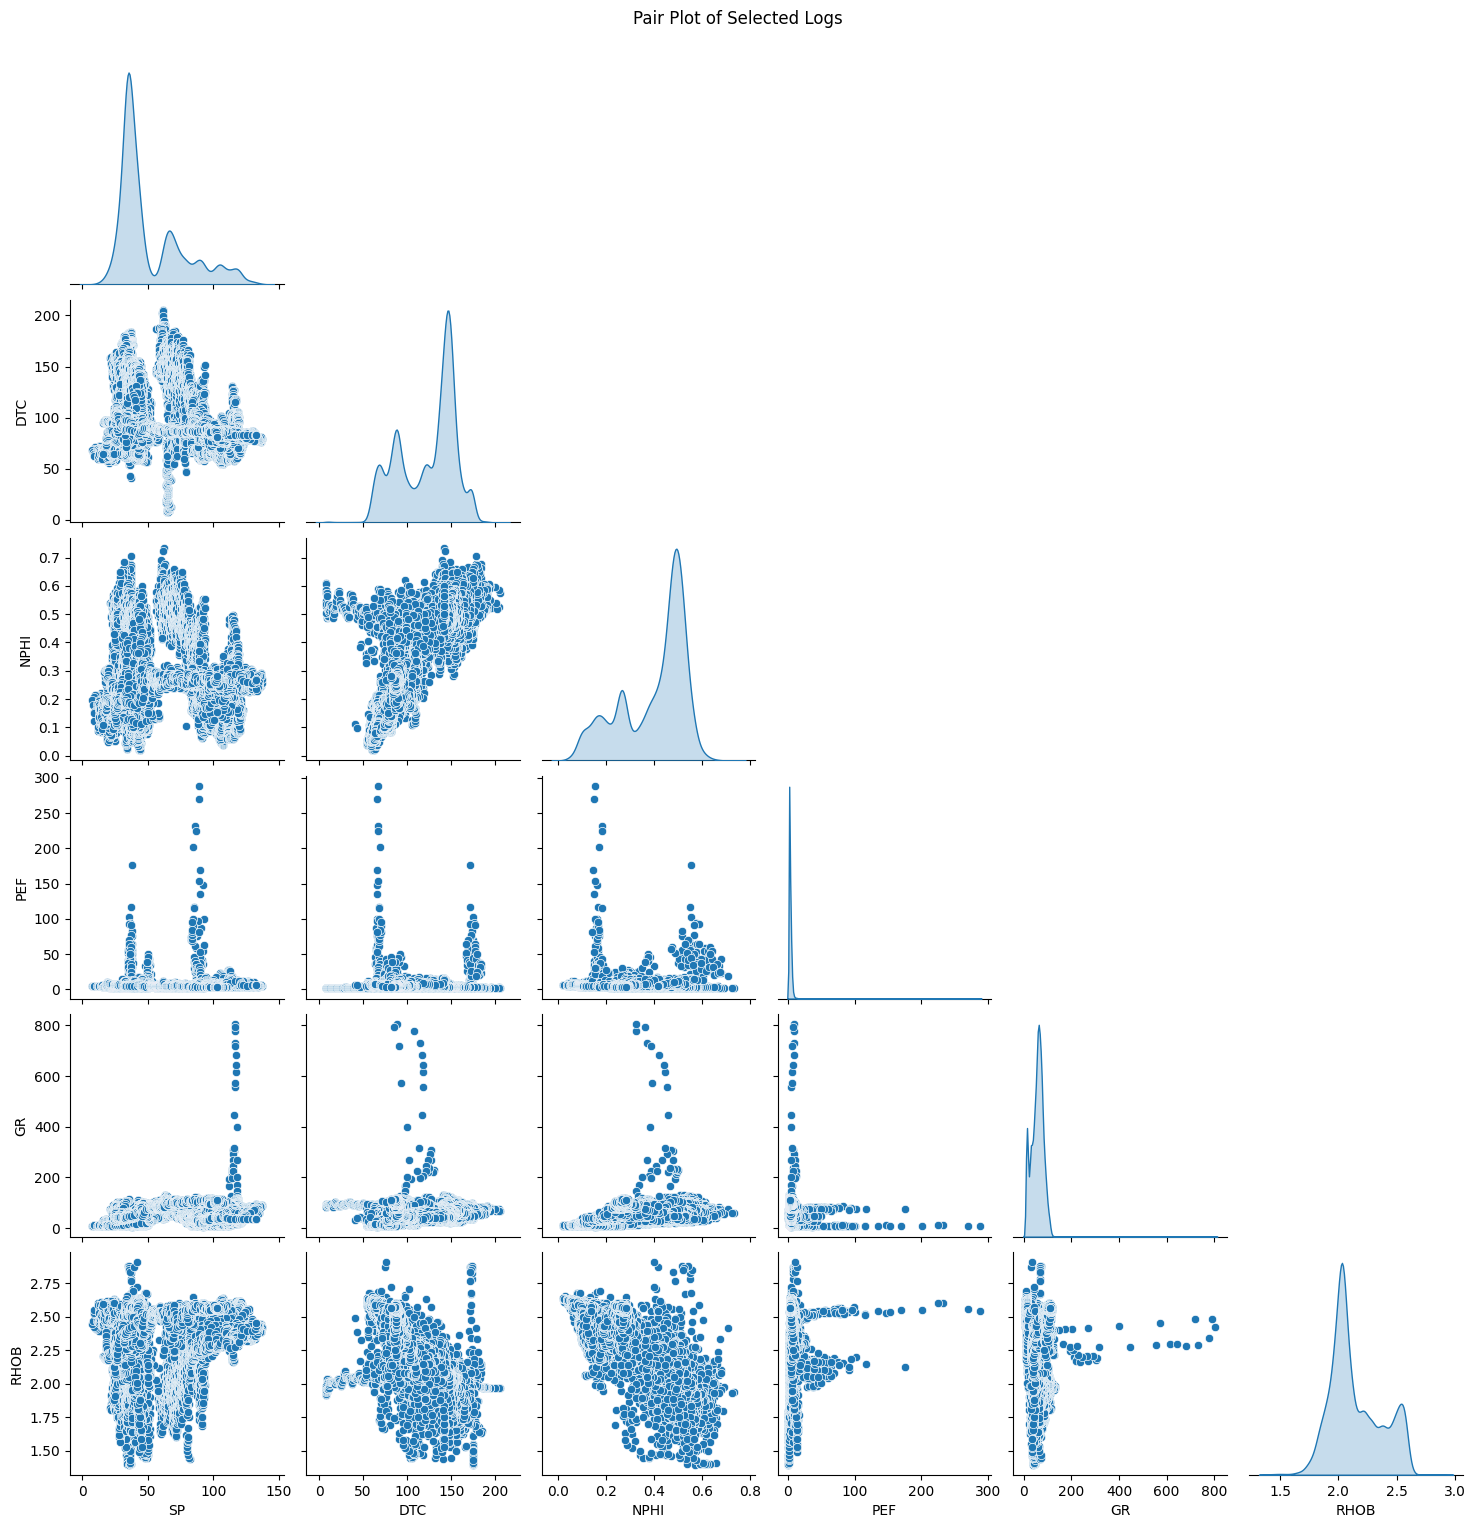

In [25]:
# Select the columns of interest
columns_to_plot = ['SP', 'DTC', 'NPHI', 'PEF', 'GR', 'RHOB']
df_to_plot = cleaned_df[columns_to_plot].dropna()  # Drop NaN values for these columns

# Create a pair plot
sns.pairplot(df_to_plot, diag_kind='kde', corner=True)

# Display the plot
plt.suptitle('Pair Plot of Selected Logs', y=1.02)
plt.show()

**A lot of the trends we see in the seaborn plots are consistent with what we would expect from well logs. For example, as NPHI increases, RHOB tends to decrease. Another place we see familiar trends is with RHOB, NPHI, and DTC. As DTC increases, RHOB tends to decrease and NPHI tends to increase, which we would expect. I also see that SP seems to form two clusters when combined with RHOB, NPHI, and DTC.  In GR and PEF logs, we see some large outliers which I will examine later on in this EDA. I also saw some interesting distributions which I will look at more closely later on.**

### Correlation Matrix Heatmap

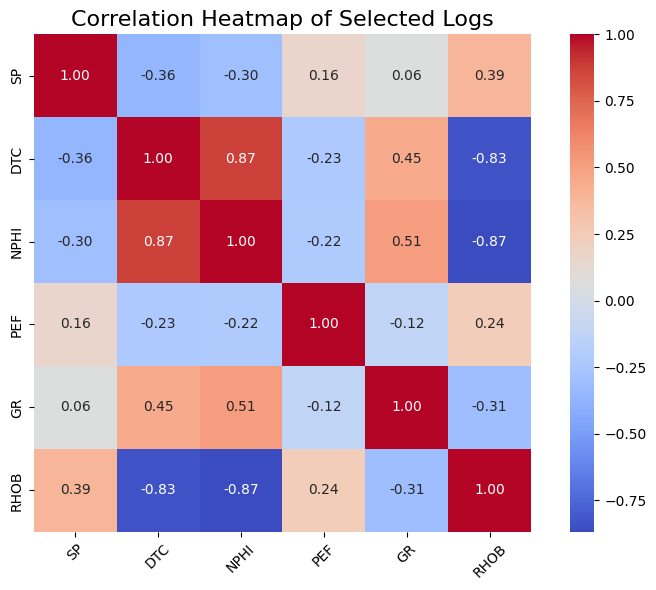

In [26]:
# Compute the correlation matrix
correlation_matrix = df_to_plot.corr()

# Set up the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

# Add labels and title
plt.title('Correlation Heatmap of Selected Logs', fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()

**As previously seen in the seaborn plots, the strongest trends are present between RHOB, DTC, and PHI. DTC and NPHI exhibit a positive trend, as both increase in formations with higher porosity, where sound waves travel slower due to fluid-filled pore spaces. On the other hand, DTC and RHOB show a negative trend, as denser rocks allow faster sound wave travel (lower DTC) while also exhibiting higher bulk density (higher RHOB). These trends are consistent with the physical properties of rock formations and their response to acoustic and density logging tools. Besides the aforementioned trends, none of the other trends are as strong, which is consistent with the seaborn plots.**

### Data Distributions

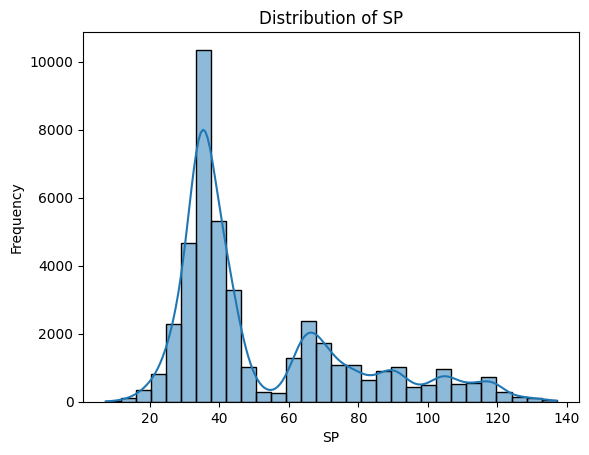

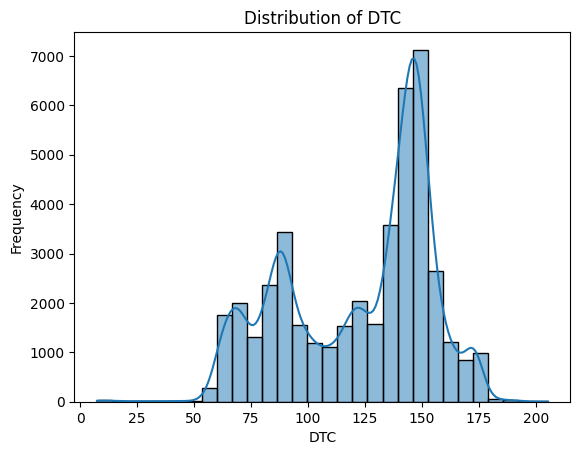

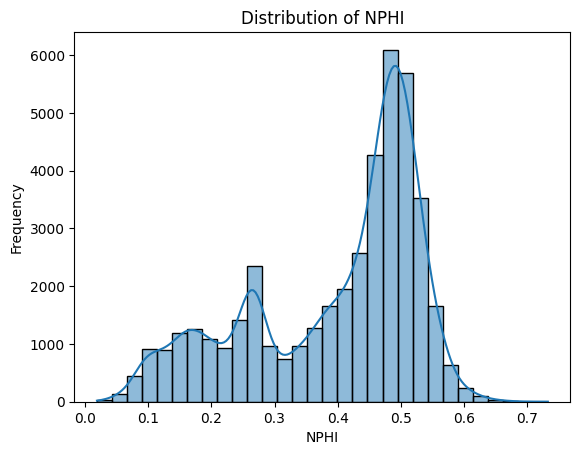

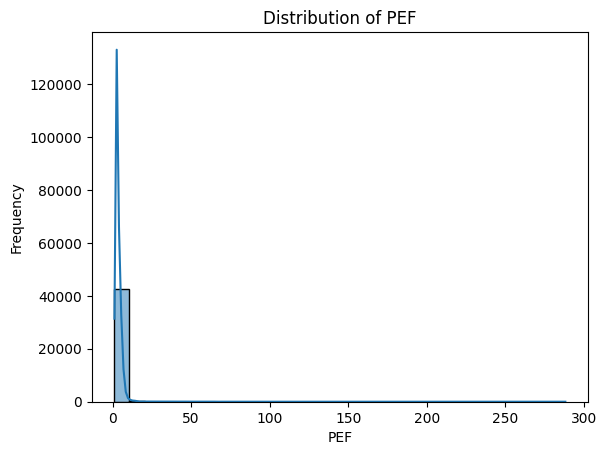

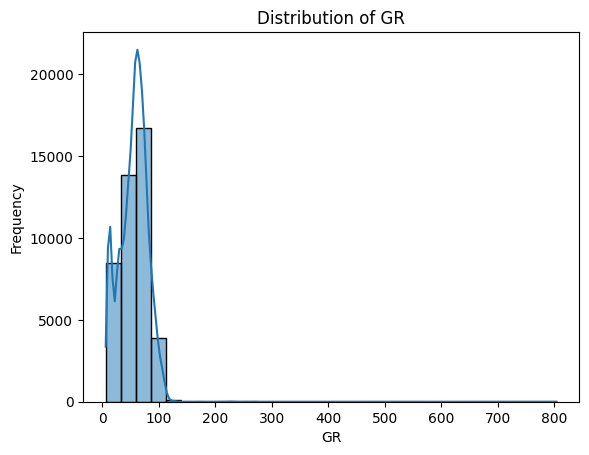

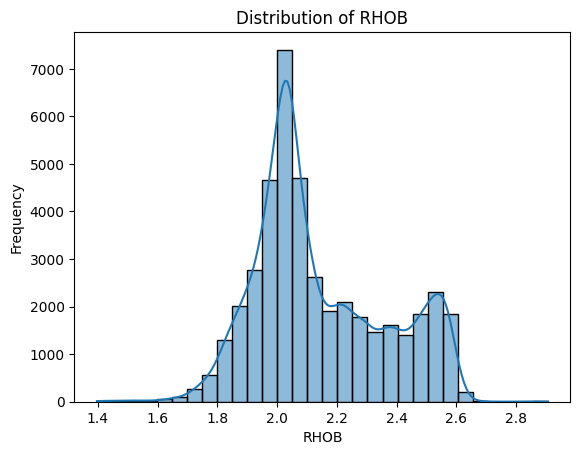

In [27]:
for col in ['SP', 'DTC', 'NPHI', 'PEF', 'GR', 'RHOB']:
    sns.histplot(cleaned_df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

**Reexamining the distributions of each log showed some really interesting trends. SP, DTC, NPHI, and RHOB have more bimodal distributions, while PEF and GR have more unimodal distributions. This makes sense for PEF and GR, as the vast majority of values are closer to 0, with the exception of some outliers. I am not completely sure why we see bimodal distributions with the others, but I think that they could represent the two dominanat lithologies present across these logs.**

### Outlier Analysis


Outliers in SP: 1049
Outlier value range for SP: [117.65735626, 137.08558655]

Outliers in DTC: 8
Outlier value range for DTC: [7.4151320457, 8.2773714066]

Outliers in NPHI: 0
No outliers detected in NPHI.

Outliers in PEF: 1490
Outlier value range for PEF: [7.314719677, 288.1036377]

Outliers in GR: 56
Outlier value range for GR: [121.66729736, 804.2989502]

Outliers in RHOB: 75
Outlier value range for RHOB: [1.3968189955, 2.9066109657]


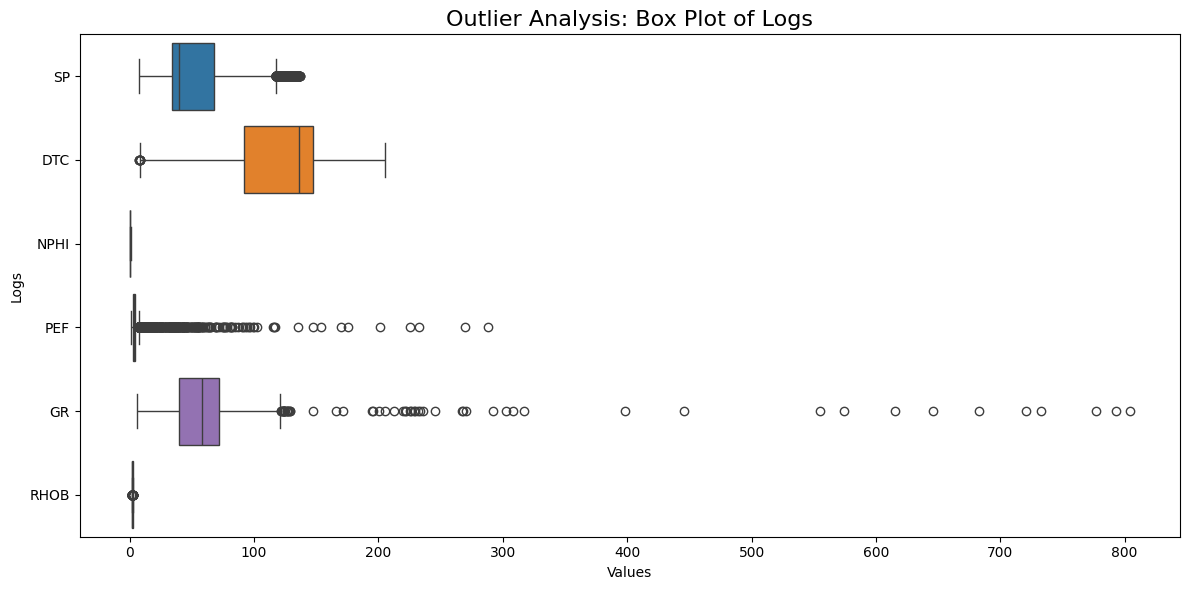

In [28]:
# Outlier analysis with outlier ranges
for col in ['SP', 'DTC', 'NPHI', 'PEF', 'GR', 'RHOB']:
    Q1 = cleaned_df[col].quantile(0.25)
    Q3 = cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = cleaned_df[(cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)]

    # Print the results
    print(f'\nOutliers in {col}: {len(outliers)}')
    if not outliers.empty:
        print(f'Outlier value range for {col}: [{outliers[col].min()}, {outliers[col].max()}]')
    else:
        print(f'No outliers detected in {col}.')

# Columns to analyze
columns_to_analyze = ['SP', 'DTC', 'NPHI', 'PEF', 'GR', 'RHOB']

# Set up the plot
plt.figure(figsize=(12, 6))

# Create a boxplot for each column
sns.boxplot(data=cleaned_df[columns_to_analyze], orient="h", showfliers=True)

# Add titles and labels
plt.title('Outlier Analysis: Box Plot of Logs', fontsize=16)
plt.xlabel('Values')
plt.ylabel('Logs')
plt.tight_layout()

# Display the plot
plt.show()

**The outlier analysis gives more insight into some of the trends we saw in the seaborn plots, and what we would expect from these logs in general. NPHI and RHOB didn't really have many large outliers, which makes sense as NPHI is measured between 0 and 1. While RHOB doesn't have a definitive range, values generally lie between 1-4 g/cc, and it is unlikely there will be outliers beyond that range. With PEF and GR, we see that most of the Gamma Ray values are around 50, and then there are quite a few outliers way higher than this range. With PEF, most of the values are around 0, and then we have a lot of outliers beyond this range. With SP, there are also a lot of outliers, except they are signficantly closer to the expected range when compared to SP and GR. Lastly, DTC doesn't have many otuliers, and follows a more normal distribution.**